In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 25 heights in inches
heights = np.linspace(52.5, 77.5, 25)
X = np.column_stack((np.ones(len(heights)), heights))  # shape (25, 2)
#for random

# Define the weight function
def w(h,w0,w1):
    return w0 + w1*h  # h in inches, w in pounds

# Calculate weights
weights = w(heights,-100.42,3.86)

# Serial numbers
serials = np.arange(1, 26)

# Print the datapoints
for i, (h, w_val) in enumerate(zip(heights, weights), start=1):
    print(f"{i:2d}. Height: {h:.2f} in, Weight: {w_val:.2f} lbs")

 1. Height: 52.50 in, Weight: 102.23 lbs
 2. Height: 53.54 in, Weight: 106.25 lbs
 3. Height: 54.58 in, Weight: 110.27 lbs
 4. Height: 55.62 in, Weight: 114.29 lbs
 5. Height: 56.67 in, Weight: 118.31 lbs
 6. Height: 57.71 in, Weight: 122.33 lbs
 7. Height: 58.75 in, Weight: 126.36 lbs
 8. Height: 59.79 in, Weight: 130.38 lbs
 9. Height: 60.83 in, Weight: 134.40 lbs
10. Height: 61.88 in, Weight: 138.42 lbs
11. Height: 62.92 in, Weight: 142.44 lbs
12. Height: 63.96 in, Weight: 146.46 lbs
13. Height: 65.00 in, Weight: 150.48 lbs
14. Height: 66.04 in, Weight: 154.50 lbs
15. Height: 67.08 in, Weight: 158.52 lbs
16. Height: 68.12 in, Weight: 162.54 lbs
17. Height: 69.17 in, Weight: 166.56 lbs
18. Height: 70.21 in, Weight: 170.58 lbs
19. Height: 71.25 in, Weight: 174.60 lbs
20. Height: 72.29 in, Weight: 178.63 lbs
21. Height: 73.33 in, Weight: 182.65 lbs
22. Height: 74.38 in, Weight: 186.67 lbs
23. Height: 75.42 in, Weight: 190.69 lbs
24. Height: 76.46 in, Weight: 194.71 lbs
25. Height: 77.5

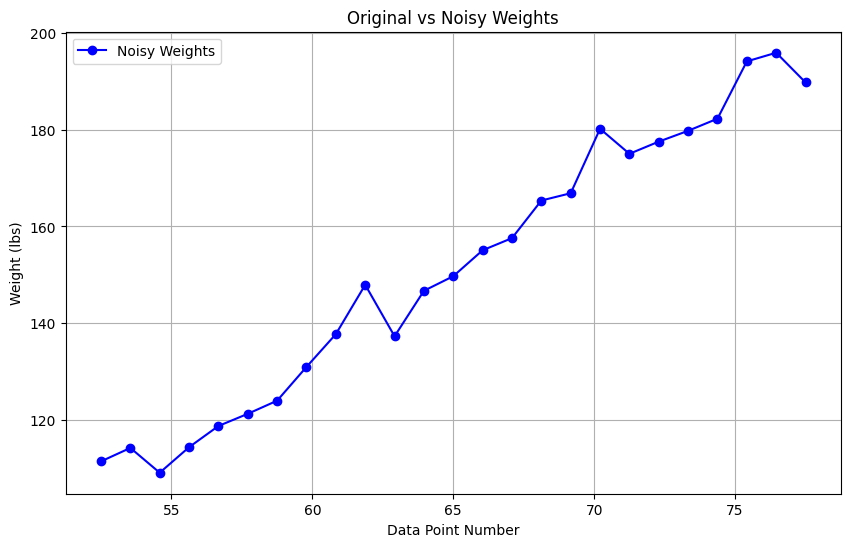

In [97]:
# Noise parameters
mean = 0
variance = 20
std_dev = np.sqrt(variance)

# Generate Gaussian noise
noise = np.random.normal(mean, std_dev, size=heights.shape)

# Add noise to original data
noisy_weights = weights + noise

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(heights, noisy_weights, 'bo-', label='Noisy Weights')
plt.xlabel('Data Point Number')
plt.ylabel('Weight (lbs)')
plt.title('Original vs Noisy Weights')
plt.legend()
plt.grid(True)
plt.show()

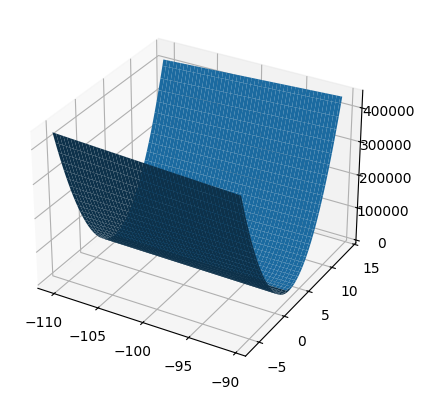

In [98]:
# Known weights
w0_center = -100.42
w1_center = 3.86

# Define a range around the known weights
w0_range = np.linspace(w0_center - 10, w0_center + 10, 100) 
w1_range = np.linspace(w1_center - 10, w1_center + 10, 100)

def Error(w,t,x): #inputs : 1)weight 2)data i.e (t = target,x = input)
 #Estimate the target
    y_pred = x @ w
    error = np.mean((t - y_pred)**2)
    #Compute and return the error
    return error

# Error surface
errors = np.zeros((len(w0_range), len(w1_range)))

for i, w0 in enumerate(w0_range):
    for j, w1 in enumerate(w1_range):
        w = np.array([w0, w1])
        errors[i, j] = Error(w, noisy_weights, X)

# Plotting the 3D error surface
W0, W1 = np.meshgrid(w0_range, w1_range)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W0, W1, errors.T)
plt.show()

In [99]:
# Find the indices of the minimum error
min_index = np.unravel_index(np.argmin(errors), errors.shape)

# Get corresponding w0 and w1 values
min_w0 = w0_range[min_index[0]]
min_w1 = w1_range[min_index[1]]

print(f"Minimum error found at:")
print(f"w0 (bias) = {min_w0}")
print(f"w1 (slope) = {min_w1}")

error_weights = np.array([min_w0,min_w1])

Minimum error found at:
w0 (bias) = -93.04626262626263
w1 (slope) = 3.758989898989899


In [100]:
def LinearRegression(X, t):
    w_opt = np.linalg.inv(X.T @ X) @ X.T @ t
    return w_opt

# Estimate weights using normal equation
regression_weights = LinearRegression(X, noisy_weights)

print("\nEstimated weights using least squares:")
print(f"w0 (bias) = {regression_weights[0]}")
print(f"w1 (slope) = {regression_weights[1]}")


Estimated weights using least squares:
w0 (bias) = -86.51418128964738
w1 (slope) = 3.6588077548767677


In [101]:
error_weights = np.array([min_w0,min_w1])
error_pred = X @ error_weights
regression_pred = X @ regression_weights

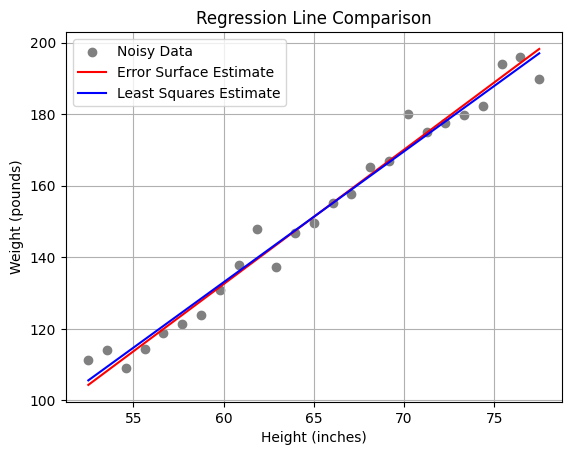

In [102]:
# Plot the noisy data
plt.scatter(heights, noisy_weights, label='Noisy Data', color='gray')

# Predicted lines
plt.plot(heights, error_pred, label='Error Surface Estimate', color='red')
plt.plot(heights, regression_pred, label='Least Squares Estimate', color='blue')

# Labels and legend
plt.xlabel("Height (inches)")
plt.ylabel("Weight (pounds)")
plt.title("Regression Line Comparison")
plt.legend()
plt.grid(True)
plt.show()

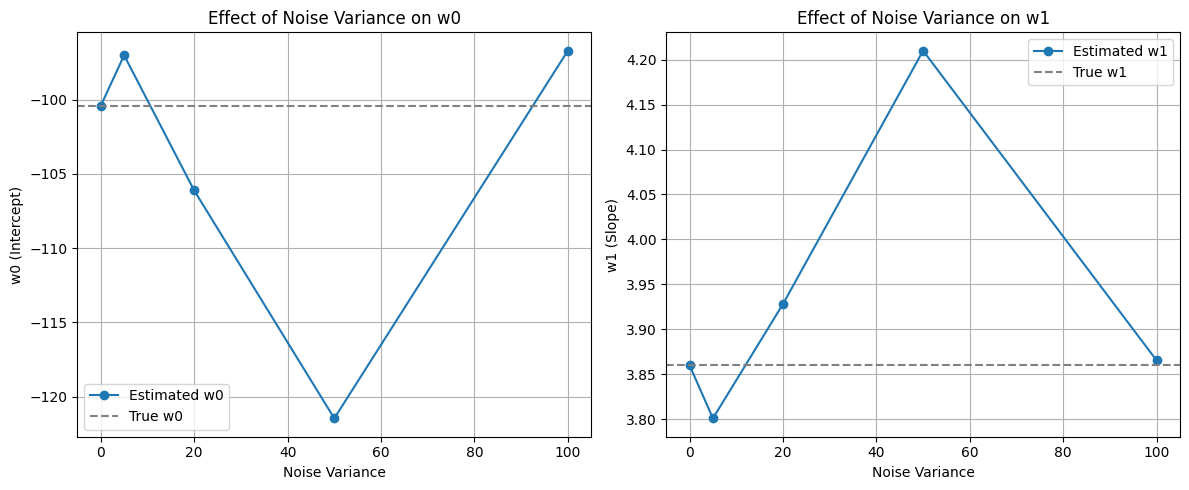

In [1]:
# Fixed parameters
np.random.seed(0)
heights = np.linspace(52.5, 77.5, 25)
true_weights = 3.86 * heights - 100.42
X = np.vstack((np.ones_like(heights), heights)).T
t_true = true_weights.reshape(-1, 1)

# Variance values to test
variances = [0, 5, 20, 50, 100]
estimated_params = []

def least_squares(X, t):
    return np.linalg.inv(X.T @ X) @ X.T @ t

# Loop over variances
for var in variances:
    noise = np.random.normal(0, np.sqrt(var), size=heights.shape)
    noisy_weights = true_weights + noise
    t_noisy = noisy_weights.reshape(-1, 1)
    w_est = least_squares(X, t_noisy).flatten()
    estimated_params.append((var, w_est[0], w_est[1]))

# Convert to numpy array for easy plotting
estimated_params = np.array(estimated_params)

# Plotting the change in w0 and w1
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(estimated_params[:, 0], estimated_params[:, 1], 'o-', label='Estimated w0')
plt.axhline(-100.42, color='gray', linestyle='--', label='True w0')
plt.xlabel('Noise Variance')
plt.ylabel('w0 (Intercept)')
plt.title('Effect of Noise Variance on w0')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(estimated_params[:, 0], estimated_params[:, 2], 'o-', label='Estimated w1')
plt.axhline(3.86, color='gray', linestyle='--', label='True w1')
plt.xlabel('Noise Variance')
plt.ylabel('w1 (Slope)')
plt.title('Effect of Noise Variance on w1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
